In [18]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [36]:
# !pip install daymetpy
# !pip install rioxarray
# !pip install Pydap
# !pip install netCDF4
# !pip install pydap xarray matplotlib rasterio rioxarray shapely


In [37]:
import geopandas as gpd
import matplotlib.pyplot as plt
import datetime as dt
import requests

from pydap.client import open_url
import xarray as xr
import time
import matplotlib.pyplot as plt
from rasterio.features import Affine, geometry_mask
import rioxarray
from shapely.geometry import mapping


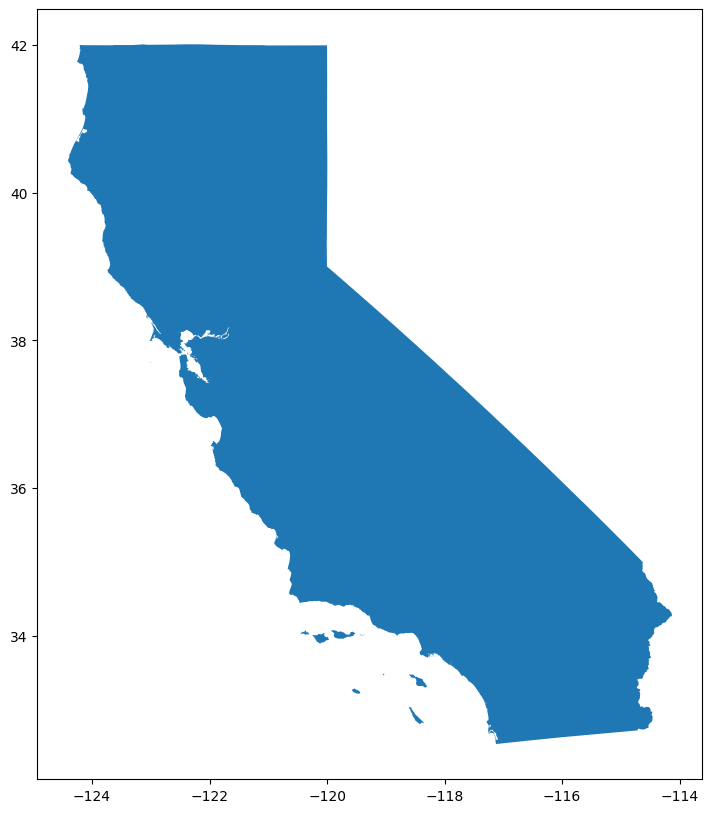

In [25]:
gdf = gpd.read_file('/content/drive/MyDrive/Moths!/data/gadm41_USA_shp/gadm41_USA_1.shp')
california = gdf[gdf['NAME_1'] == 'California']
fig, ax = plt.subplots(figsize=(10, 10))
california.plot(ax=ax)
plt.show()


In [26]:
california_poly = california
california_poly_4326 = california_poly.to_crs(epsg=4326)
bbox = california_poly_4326.bounds.values.tolist()[0]


In [31]:
start_date = dt.datetime(2010, 1, 1)
end_date = dt.datetime(2011, 1, 1)
var = 'prcp'


In [33]:
# Updated DOI for the latest version of the Daymet dataset
daymet_doi = '10.3334/ORNLDAAC/2129'
cmrurl = 'https://cmr.earthdata.nasa.gov/search/'

doisearch = cmrurl + 'collections.json?doi=' + daymet_doi
response = requests.get(doisearch)
response_json = response.json()

print("API Response:", response_json)

if 'feed' in response_json and 'entry' in response_json['feed'] and len(response_json['feed']['entry']) > 0:
    concept_id = response_json['feed']['entry'][0]['id']
    print("Concept ID for the latest version:", concept_id)
else:
    print("No records found for DOI:", daymet_doi)


API Response: {'feed': {'updated': '2023-10-26T21:46:51.764Z', 'id': 'https://cmr.earthdata.nasa.gov:443/search/collections.json?doi=10.3334/ORNLDAAC/2129', 'title': 'ECHO dataset metadata', 'entry': [{'processing_level_id': '4', 'cloud_hosted': True, 'boxes': ['14.07 -178.13 82.91 -53.06'], 'time_start': '1950-01-01T00:00:00.000Z', 'version_id': '4.5', 'updated': '2023-06-12T20:26:21.000Z', 'dataset_id': 'Daymet: Daily Surface Weather Data on a 1-km Grid for North America, Version 4 R1', 'has_spatial_subsetting': False, 'has_transforms': False, 'has_variables': False, 'data_center': 'ORNL_CLOUD', 'short_name': 'Daymet_Daily_V4R1_2129', 'organizations': ['ORNL_DAAC'], 'title': 'Daymet: Daily Surface Weather Data on a 1-km Grid for North America, Version 4 R1', 'coordinate_system': 'CARTESIAN', 'summary': 'This dataset provides Daymet Version 4 R1 data as gridded estimates of daily weather parameters for North America, Hawaii, and Puerto Rico. Daymet variables include the following para

In [34]:
temporal_str = start_date.strftime('%Y-%m-%dT%H:%M:%SZ') + ',' + end_date.strftime('%Y-%m-%dT%H:%M:%SZ')
granulesearch = cmrurl + 'granules.json?collection_concept_id=' + concept_id + '&page_size=1000&temporal=' + temporal_str + '&bounding_box[]=' + ','.join(map(str, bbox))
response = requests.get(granulesearch)
granules = response.json()['feed']['entry']
granule_names = [g['title'] for g in granules if var in g['title']]


In [38]:
thredds_url = 'https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/1840/' # ORNL DAAC TDS OPeNDAP URL
                                                                           # for Daymet V4 Daily Files

before = time.time()
cnt = 0
for g_name in granule_names:
    print(' ***GRANULE_NAME*** ---->', g_name)
    granule_dap = thredds_url + g_name.replace('Daymet_Daily_V4.','')
    print(granule_dap)

    # Using pydap's open_url
    thredds_ds = open_url(granule_dap)

    # Xarray DataSet - opening dataset via remote OPeNDAP
    ds = xr.open_dataset(xr.backends.PydapDataStore(thredds_ds), decode_coords="all")

    temp = ds['prcp'].sel(x=slice(lccbounds.minx[0], lccbounds.maxx[0]), y=slice(lccbounds.maxy[0], lccbounds.miny[0]))

    if cnt == 0:
        prcp = temp
    else:
        prcp = xr.concat([prcp, temp], dim="time")

    cnt += 1

# save to netcdf
prcp.to_netcdf(var + '_tdssubset.nc')
print("Processing Time: ", time.time() - before, 'seconds')


 ***GRANULE_NAME*** ----> Daymet_Daily_V4R1.daymet_v4_daily_na_prcp_2010.nc
https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/1840/Daymet_Daily_V4R1.daymet_v4_daily_na_prcp_2010.nc


Exception: ignored